In [1]:
import pandas as pd
import numpy as np

## Random Value Imputation For Numerical Features

In [2]:
ds = pd.read_csv("train.csv",usecols=['Age', 'Fare', 'Survived'])

In [3]:
# lets check the missing values
ds.isnull().mean()

Survived    0.000000
Age         0.198653
Fare        0.000000
dtype: float64


### Note
Imputation should be done in train as well as test set. For now we will consider only the training set.

In [7]:
# lets generate some random values from Age columns
random_sample=ds['Age'].dropna().sample()
print(random_sample)

11    58.0
Name: Age, dtype: float64


In [10]:
# lets create a map that will be used to fill the NaN values
random_sample_map=ds['Age'].dropna().sample(ds['Age'].isnull().sum(),random_state=10)
print(random_sample_map)

728    25.0
555    62.0
426    28.0
278     7.0
617    26.0
       ... 
696    44.0
486    35.0
44     19.0
62     45.0
571    53.0
Name: Age, Length: 177, dtype: float64


In [12]:
# As pandas need to have same index to merge the dataset, lets generate the index of the rows having null values
ds[ds['Age'].isnull()].index

Int64Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
            ...
            832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
           dtype='int64', length=177)

Now we will combine the above codes and create a function impute_nan that will replace the NaN values with random sampling

In [61]:
def impute_nan(ds,variable):
  # make a copy from the original variable, with NA
  ds[variable+'_random'] = ds[variable]
  random_sample_map=ds[variable].dropna().sample(ds[variable].isnull().sum(),random_state=10)
  # Explanation of above code
  # 1) dropna() removes the NaN values from the original variable, allowing us 
  # to generate random values that are not NaN

  # 2) sample() is the method that will do the random sampling.

  # 3) ds[variable].isnull().sum() gives the total number of missing values, so 
  # that we can generate same number of random samples.

  # 4) random_state sets the seed for reproducibility, so that we extract 
  # always the same random values, every time we run this notebook

  # now this random_sample_map will have random values to be filled in palce of 
  # NaN


  # as pandas need to have same index to merge the dataset
  random_sample_map.index = ds[ds[variable].isnull()].index
  # now we replace the NaN values with the random sample data
  ds.loc[ds[variable].isnull(), variable+"_random"] = random_sample_map


In [18]:
impute_nan(ds, 'Age')

In [20]:
ds.head(10)

,Survived,Age,Fare,Age_random
0,0,22.0,7.2500,22.0
1,1,38.0,71.2833,38.0
2,1,26.0,7.9250,26.0
3,1,35.0,53.1000,35.0
4,0,35.0,8.0500,35.0
5,0,NaN,8.4583,25.0
6,0,54.0,51.8625,54.0
7,0,2.0,21.0750,2.0
8,1,27.0,11.1333,27.0
9,1,14.0,30.0708,14.0


We can see that the NaN values have been replace with some random samples from the Age column itself

In [22]:
# let's compare the variance after mean / median imputation.
# There is some change in variance, however it is very small in comparision to
# other computation techniques


print('Original variable variance: ', ds['Age'].var())
print('Variance after random sampling imputation: ', ds['Age_random'].var())

Original variable variance:  211.01912474630802
Variance after random sampling imputation:  209.06726893075574


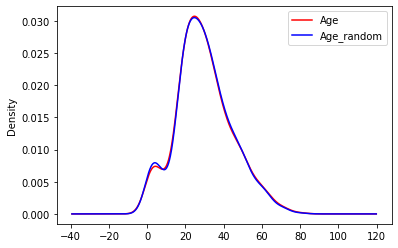

In [24]:
# lets compare the plot
# we can see that the distribution of the variable after
# random sample imputation is almost exactly the same as the original

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
ds['Age'].plot(kind="kde", ax=ax, color="red")
ds['Age_random'].plot(kind="kde", ax=ax, color="blue")


lines,_=ax.get_legend_handles_labels()
ax.legend(lines, ['Age','Age_random'], loc="best")

We can see that random sampling preserved the distribution unlike other imputation techniques.

In [25]:
# the covariance of Age with Fare is also less affected by this
# imputation technique compared to mean or median imputation

ds[['Fare', 'Age', 'Age_random']].cov()

,Fare,Age,Age_random
Fare,2469.436846,73.849030,69.552994
Age,73.849030,211.019125,211.019125
Age_random,69.552994,211.019125,209.067269


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


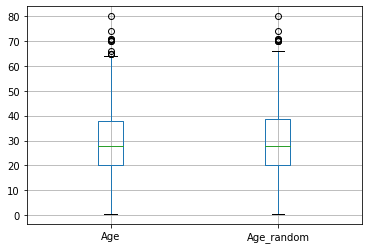

In [27]:
# The outliers are also less affected by this imputation
# technique

# Let's find out using a boxplot
ds[['Age', 'Age_random']].boxplot()

So, random sample imputation offers all the advantages provided by the preservation of the original distribution. And that is a big plus, particularly, if you care about distribution and outliers for your machine learning models. This is particularly relevant for linear models. but not so important for tree based algorithms.

### Important
In above random sampling we have controlled the randomness by providing seed i.e random_state. But doing that would assign same random values to all the NaN values, which eventually be same as arbitrary value imputation. 



In [30]:
values_ls = []

for i in range(10):
    # extract a random value, just 1, now with seed
    sampled_value = ds['Age'].dropna().sample(1, random_state=10)
    # add random value to the list
    values_ls.append(float(sampled_value))


In [31]:
print(values_ls)

[25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0]


We don't want that behaviour either.

Therefore, we want our seed to change observation per observation, but in a controlled manner, so that 2 observations that are exactly the same, receive the same imputed random values. But 2 observations that are different, receive different imputed random values.

### Controlling the element of randomness by varying the seed
We can assign a different seed to each observation, and in fact, we can make this seed depend on an alternative variable of the same observation, thus, thinking in the Titanic dataset, if 2 passengers paid exactly the same Fare, they would get exactly the same probability of survival (when Age is missing).

In [32]:
# let's pick one observation with NaN value in Age


example = ds[ds['Age'].isnull()].head(1)
example

,Survived,Age,Fare,Age_random
5,0,NaN,8.4583,25.0


Now we take Fare column values as random seed

In [34]:
int(example['Fare'])

8

In [36]:
values_ls = []

for i in range(10):
    # extract a random value, just 1, now with seed
    sampled_value = ds['Age'].dropna().sample(1, random_state=int(ds['Fare'][i]))
    # add random value to the list
    values_ls.append(float(sampled_value))


In [37]:
# lets see the random values
print(values_ls)

[29.0, 54.0, 29.0, 51.0, 30.0, 30.0, 52.0, 46.0, 18.0, 42.0]


As we can see that our problem has been solved! This is a way of controlling the randomness. By using the fare column values to set the random state, we guarantee that for 2 passengers with an equal fare, the age will be replaced with the same number, and therefore, the 2 passengers will get the same probability of survival.

### Note!!
In real life, we will build models that use tens of variables or more. So, in cases like that, we have to come up with 3-5 most important variables that has the strongest impact on the output of the machine learning model, and combining them to create the random state. Therefore, customers that share the 3-5 main variable values, will get the same scores.

## Random Value Inputation For Categorical Features

In [38]:
pwd

'/content'

In [49]:
ds = pd.read_csv('train_housing.csv')

In [50]:
ds.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [51]:
# lets find the columns having categorical features
cat_features =[ x for x in ds.columns if ds[x].dtypes=='O']

In [52]:
print(cat_features)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [55]:
# lets check the missing values percentage
ds[cat_features].isnull().mean()

MSZoning         0.000000
Street           0.000000
Alley            0.937671
LotShape         0.000000
LandContour      0.000000
Utilities        0.000000
LotConfig        0.000000
LandSlope        0.000000
Neighborhood     0.000000
Condition1       0.000000
Condition2       0.000000
BldgType         0.000000
HouseStyle       0.000000
RoofStyle        0.000000
RoofMatl         0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
MasVnrType       0.005479
ExterQual        0.000000
ExterCond        0.000000
Foundation       0.000000
BsmtQual         0.025342
BsmtCond         0.025342
BsmtExposure     0.026027
BsmtFinType1     0.025342
BsmtFinType2     0.026027
Heating          0.000000
HeatingQC        0.000000
CentralAir       0.000000
Electrical       0.000685
KitchenQual      0.000000
Functional       0.000000
FireplaceQu      0.472603
GarageType       0.055479
GarageFinish     0.055479
GarageQual       0.055479
GarageCond       0.055479
PavedDrive       0.000000
PoolQC      

In [57]:
# As there are lot of categorical features for practice we take only 2 of them.
ds = pd.read_csv('train_housing.csv', usecols=['BsmtQual', 'FireplaceQu', 'SalePrice'])

In [59]:
# let's inspect the percentage of missing values in each variable
ds.isnull().mean()

BsmtQual       0.025342
FireplaceQu    0.472603
SalePrice      0.000000
dtype: float64

In [62]:
# lets use the impute_nan function created above to fill the NaN values
impute_nan(ds,'BsmtQual')
impute_nan(ds,'FireplaceQu')

In [63]:
# lets check if the null values are handled or not
ds.isnull().sum()

BsmtQual               37
FireplaceQu           690
SalePrice               0
BsmtQual_random         0
FireplaceQu_random      0
dtype: int64

As we can see that the null values has been handled.

In [64]:
# let's caompre the effect of the imputation on the distribution of the
# categories and the target within those categories

def categorical_distribution(ds, variable, variable_random):
    tmp = pd.concat(
        [
            # percentage of observations per category, original variable
            ds[variable].value_counts() / len(ds[variable].dropna()),

            # percentage of observations per category, imputed variable
            ds[variable_random].value_counts() / len(ds)
        ],
        axis=1)

    # add column names
    tmp.columns = ['original', 'random']

    return tmp

In [66]:
# let run the function for categorical variable
categorical_distribution(ds, 'BsmtQual', 'BsmtQual_random')

,original,random
TA,0.456079,0.453425
Gd,0.434294,0.436301
Ex,0.085032,0.084247
Fa,0.024596,0.026027


In [67]:
# let run the function for categorical variable
categorical_distribution(ds, 'FireplaceQu', 'FireplaceQu_random')

,original,random
Gd,0.493506,0.495205
TA,0.406494,0.406849
Fa,0.042857,0.042466
Ex,0.031169,0.030822
Po,0.025974,0.024658


We can conclude that the percentage of observations within each category is very similar in the original and imputed variables, for both BsmtQual where NA is low and FireplaceQu where NA is high.

In [68]:
# let's compare the plot 
def func_plot(ds, variable, target):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for category in ds[variable].dropna().unique():
        ds[ds[variable]==category][target].plot(kind='kde', ax=ax)
    
    # add the legend
    lines, labels = ax.get_legend_handles_labels()
    labels = ds[variable].dropna().unique()
    ax.legend(lines, labels, loc='best')
    
    plt.show()

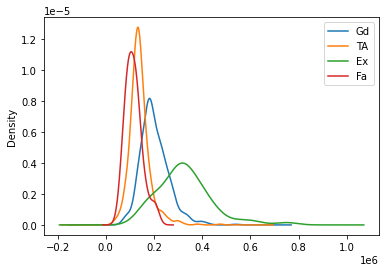

In [69]:
func_plot(ds, 'BsmtQual', 'SalePrice')


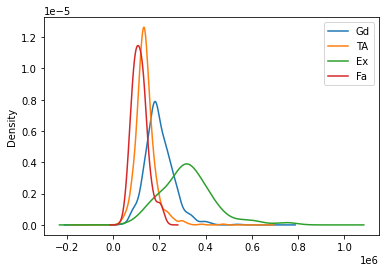

In [71]:
func_plot(ds, 'BsmtQual_random', 'SalePrice')


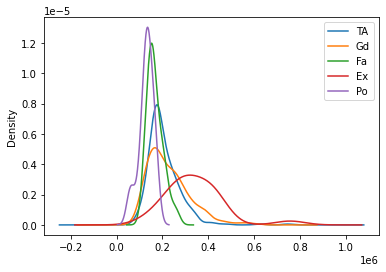

In [72]:
func_plot(ds, 'FireplaceQu', 'SalePrice')

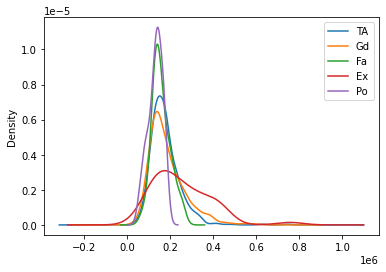

In [73]:
func_plot(ds, 'FireplaceQu_random', 'SalePrice')


### NOTE:
We can do random sample imputation using the package Feature-engine in just a couple of lines